# Libraries

In [67]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
#pip install imbalanced-learn
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Load and join data

In [2]:
users = pd.read_csv("users.csv")
merchants = pd.read_csv("merchants.csv")
print(users.head())
print(f'The number of unique users is {len(pd.unique(users['user_id']))}') #same as the total number of rows 
print(merchants.head())
print(f'The number of unique merchants is {len(pd.unique(merchants['merchant_id']))}') #same as the total number of rows 

  user_id  age     sex    education primary_source_of_income  \
0  U00001   56   Other  High School               Employment   
1  U00002   36  Female     Bachelor                 Business   
2  U00003   70   Other  High School              Student Aid   
3  U00004   38   Other  High School                  Savings   
4  U00005   61    Male  High School               Employment   

   sum_of_monthly_installments  sum_of_monthly_expenses  country signup_date  \
0                       477.69                   243.18  Finland  2021-04-01   
1                        31.60                   737.76   France  2020-07-07   
2                       275.72                  1477.50  Finland  2022-08-23   
3                       288.29                  1135.03  Belgium  2022-05-21   
4                         7.00                   892.76    Italy  2022-03-15   

   risk_score  
0    0.571079  
1    0.705268  
2    0.429579  
3    0.581384  
4    0.420227  
The number of unique users is 20000
  

In [3]:
with open("transactions.json") as f:
    data = [json.loads(line) for line in f] #nested structure requires line-by-line load

transactions = pd.json_normalize(data) #transform JSON to tabular
print(f'The number of unique transactions is {len(pd.unique(transactions['transaction_id']))}')
transactions.head()

The number of unique transactions is 500000


,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,location.lat,location.long
0,TX000000,2022-06-17T23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,145,0,0,40.057938,14.959737
1,TX000001,2022-01-04T15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,32,1,0,42.059350,1.596625
2,TX000002,2022-09-09T21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,604,1,0,50.923432,21.795262
3,TX000003,2023-11-20T06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,1031,1,0,56.833396,-9.881566
4,TX000004,2022-04-28T08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,330,0,0,54.042996,2.168516


We want to keep all transactions and add all possible data about users and merchants. Hence we use left join procedure. 

In [4]:
df_1 = pd.merge(transactions, users, on="user_id", how='left') 
print(f'First left join: the number of total rows is {len(df_1)}')
df = pd.merge(df_1, merchants, on="merchant_id", how='left', suffixes=['_user', '_merchant']) #use suffixes to distinguish country columns
print(f'Second left join: the number of total rows is {len(df)}')

First left join: the number of total rows is 500000
Second left join: the number of total rows is 500000


# EDA

Exploratory Data Analysis includes:
- Missing values
- Variable transformation (Time-Based analysis included)
- Visualized feature distribution (fraud vs non-fraud)
- Outlier detection
- Correlation analysis
- Class imbalance

In [5]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17T23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04T15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
2,TX000002,2022-09-09T21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,...,Italy,2021-05-18,0.393848,gaming,Denmark,0.608070,5,98.93,75,0
3,TX000003,2023-11-20T06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,...,Portugal,2021-09-05,0.393405,electronics,Portugal,0.592656,4,21.60,82,0
4,TX000004,2022-04-28T08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0


In [6]:
df.isna().sum()

transaction_id                        0
timestamp                             0
user_id                               0
merchant_id                           0
amount                                0
channel                               0
currency                              0
device                                0
payment_method                        0
is_international                      0
session_length_seconds                0
is_first_time_merchant                0
is_fraud                              0
location.lat                          0
location.long                         0
age                                   0
sex                                   0
education                         96566
primary_source_of_income              0
sum_of_monthly_installments           0
sum_of_monthly_expenses               0
country_user                          0
signup_date                           0
risk_score                            0
category                              0


In [7]:
df[pd.isna(df['education'])]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,country_user,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
5,TX000005,2023-07-22T08:39:00,U01335,M0272,83.21,mobile,EUR,Android,debit_card,1,...,Poland,2020-09-09,0.533121,education,Finland,0.662969,5,166.18,80,1
17,TX000017,2022-01-07T16:31:00,U16459,M0724,122.11,mobile,EUR,Android,debit_card,1,...,Austria,2021-02-10,0.694816,restaurants,France,0.284208,1,45.75,9,1
19,TX000019,2022-01-27T23:40:00,U02026,M0618,178.94,in-store,EUR,Android,credit_card,1,...,Germany,2024-10-09,0.621181,grocery,Ireland,0.825521,1,59.41,19,0
25,TX000025,2023-05-31T11:00:00,U03144,M0962,112.38,mobile,EUR,Web,debit_card,1,...,France,2023-11-05,0.469093,restaurants,Poland,0.607160,6,90.67,52,0
27,TX000027,2022-05-05T20:25:00,U13107,M0443,38.21,in-store,EUR,Web,debit_card,0,...,Ireland,2024-06-26,0.542685,clothing,Ireland,1.000000,2,28.56,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499982,TX499982,2022-06-27T06:24:00,U17105,M0705,124.89,online,EUR,iOS,debit_card,1,...,Ireland,2022-01-30,0.416165,clothing,Poland,1.000000,5,134.49,44,1
499986,TX499986,2022-04-24T00:53:00,U08749,M0232,17.86,online,EUR,iOS,mobile_payment,0,...,France,2022-04-17,0.598752,restaurants,France,0.456625,5,137.87,38,1
499988,TX499988,2023-01-12T21:14:00,U16974,M0243,107.19,online,EUR,Android,mobile_payment,1,...,Sweden,2024-08-27,0.556321,education,Spain,0.972907,1,230.92,21,1
499989,TX499989,2022-10-13T09:15:00,U01512,M0062,59.98,online,EUR,iOS,bank_transfer,1,...,Italy,2021-03-01,0.363156,grocery,Finland,0.796693,3,16.91,103,0


Pandas 2.2.2 treats None as a missing value. We assume that in the user data context, None means a separate category - lack of education in general. 

In [8]:
df['education'] = df['education'].fillna('No education')

In [38]:
#df.isna().sum()
#df[df['education']=='No education']

In [9]:
df.columns

Index(['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount',
       'channel', 'currency', 'device', 'payment_method', 'is_international',
       'session_length_seconds', 'is_first_time_merchant', 'is_fraud',
       'location.lat', 'location.long', 'age', 'sex', 'education',
       'primary_source_of_income', 'sum_of_monthly_installments',
       'sum_of_monthly_expenses', 'country_user', 'signup_date', 'risk_score',
       'category', 'country_merchant', 'trust_score',
       'number_of_alerts_last_6_months', 'avg_transaction_amount',
       'account_age_months', 'has_fraud_history'],
      dtype='object')

In [10]:
df['currency'].value_counts()

currency
EUR    500000
Name: count, dtype: int64

Variables processing:
- Delete the keys useless for modelling: **transaction_id**, **merchant_id** (there is a specific column has_fraud_history), **currency** (all transactions in the training dataset are in EUR) 

- May be transformed: **timestamp** (day period - morning, day, evening, night), **user_id** (a flag to link to a fraud history - similar to merchant), **signup_date** (months of cooperation started from today), **location.lat/long** (transaction country to compare with the user and merchant one - if similar then 1)

- Ready for the further EDA: **amount**, **is_international**, **session_length_seconds**, **is_first_time_merchant**, **age**, **sum_of_monthly_installments**, **sum_of_monthly_expenses**, **risk_score**, **trust_score**, **number_of_alerts_last_6_months**, **avg_transaction_amount**, **account_age_months**, **has_fraud_history**

- Requires One-Hot or Label Encoding: **channel**, **device**, **payment_method**, **sex**, **primary_source_of_income**, **category**, **country_user** (too many categories), **country_merchant** (too many categories)

- Requires Ordinal Encoding: **education**

- Target: **is_fraud**  

### Variable transformation 

In [11]:
df = df.drop(['transaction_id', 'merchant_id', 'currency'], axis=1)

First, we conduct time-based analysis to decide whether a year, month, day, hour period impacts the fraud frequency. We aim to answer the question - are there any seasonality patterns? Time dimensions include month, weekday, hour.

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
def plot_fraud_by_time(df, time_unit='hour'):
    '''
    Plots fraud count by time unit: 'hour', 'weekday', 'month', 'year'.
    '''
    #Extract time features
    if time_unit == 'hour':
        df['time_feature'] = df['timestamp'].dt.hour
        categories = list(range(24))
    elif time_unit == 'weekday':
        df['time_feature'] = df['timestamp'].dt.day_name()
        categories = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    elif time_unit == 'month':
        df['time_feature'] = df['timestamp'].dt.month_name()
        categories = ['January', 'February', 'March', 'April', 'May', 'June',
                      'July', 'August', 'September', 'October', 'November', 'December']
    elif time_unit == 'year':
        df['time_feature'] = df['timestamp'].dt.year
        categories = sorted(df['time_feature'].unique())
    else:
        df['time_feature'] = df[time_unit]

    counts = df.groupby(['time_feature', 'is_fraud']).size().unstack(fill_value=0)
    
    if 'categories' in locals():
        counts = counts.reindex(categories) #only if available

    #plot
    ax = counts.plot(kind='bar', figsize=(12, 6))
    plt.title(f'Fraud vs Non-Fraud Count by {time_unit.capitalize()}')
    plt.xlabel(time_unit.capitalize())
    plt.ylabel('Transaction Count')
    plt.legend(['Non-Fraud', 'Fraud'], title='Transaction Type')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()

    for idx in range(len(counts)): #annotate with fraud %
        total = counts.iloc[idx].sum()
        fraud_count = counts.iloc[idx][1]
        if fraud_count > 0 and total > 0:
            fraud_pct = 100 * fraud_count / total
            ax.text(idx + 0.2, fraud_count + max(counts[1]) * 0.01, f'{fraud_pct:.1f}%', ha='center', va='bottom', fontsize=9, rotation=90)

    plt.show()

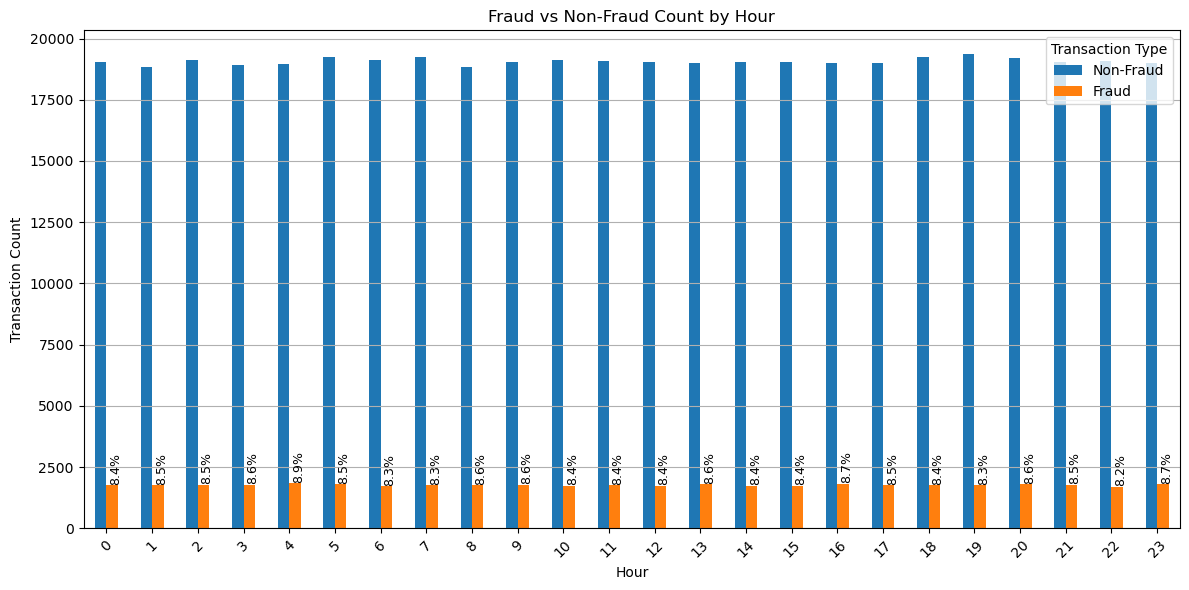

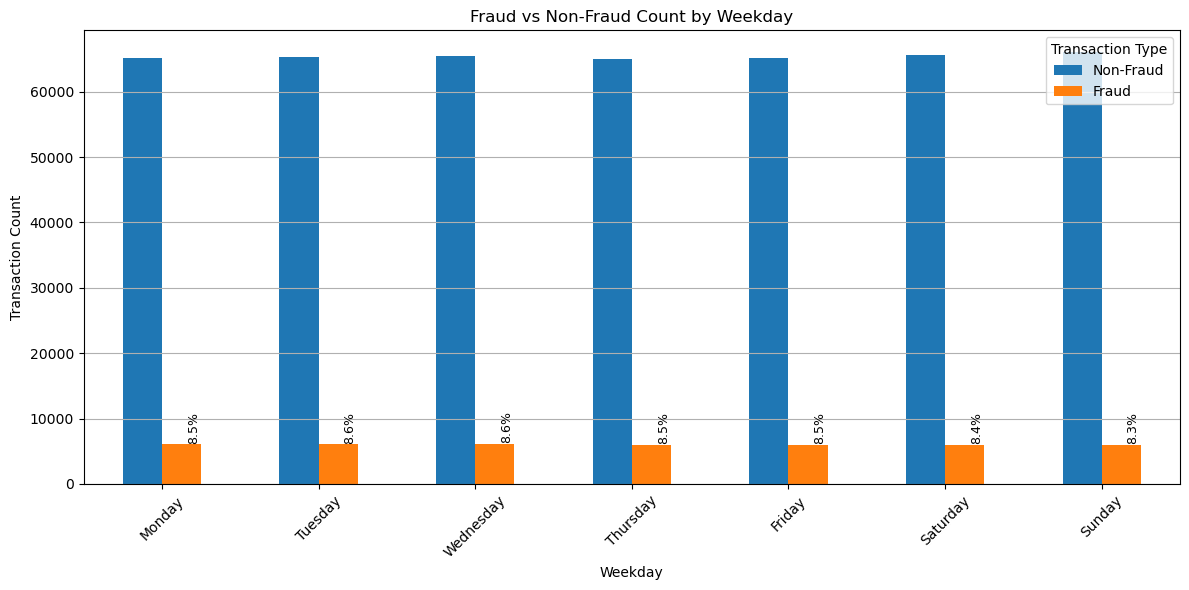

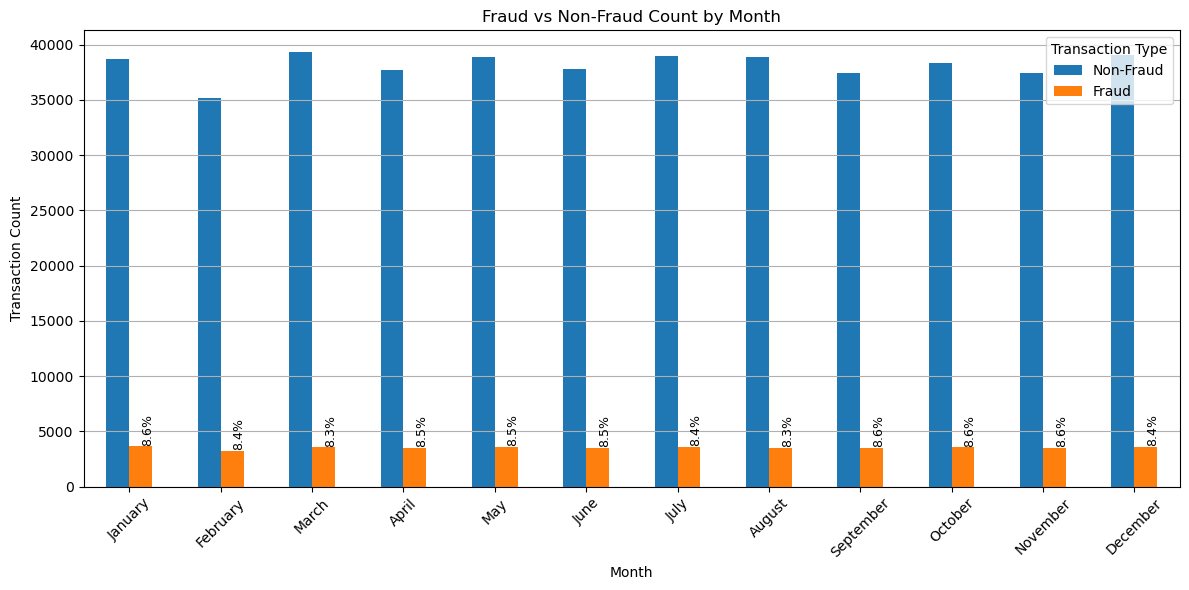

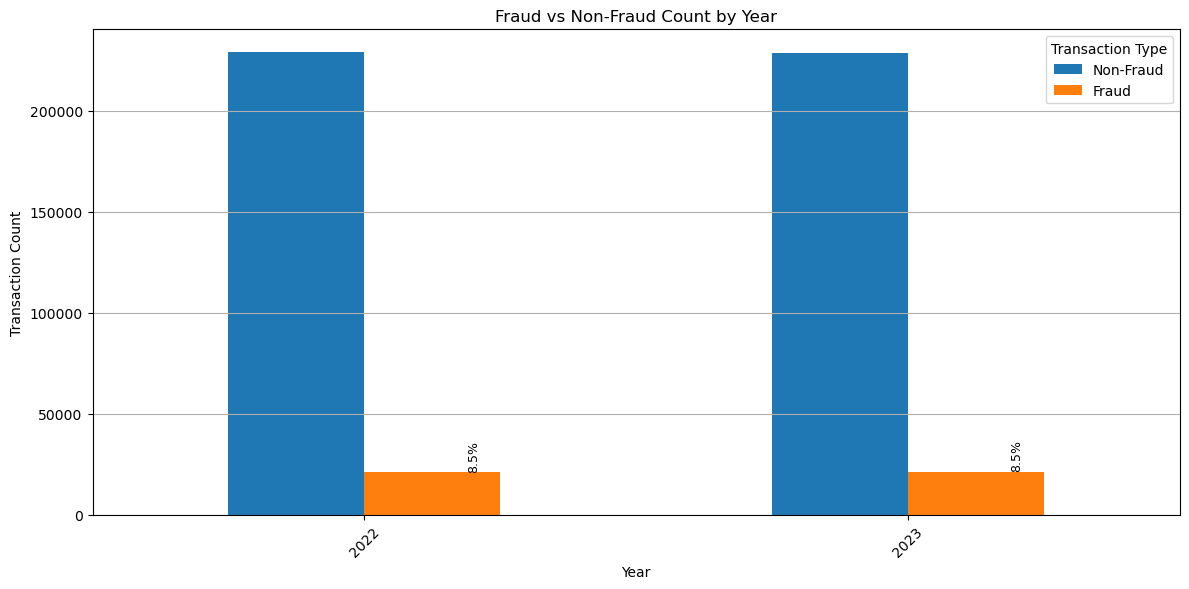

In [14]:
plot_fraud_by_time(df, time_unit='hour')
plot_fraud_by_time(df, time_unit='weekday')
plot_fraud_by_time(df, time_unit='month')
plot_fraud_by_time(df, time_unit='year')

We do not identify certain patterns. At 4 a.m. the total number of frauds is higher but it may be a coincidence (noise in statistical terms). As a next step, we want to generalize the hour time dimension to the time of a day. 

In [15]:
def map_time_of_day(hour):
    '''Map hour to part of day'''
    if 6 <= hour < 11:
        return 'morning'
    elif 11 <= hour < 17:
        return 'day'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

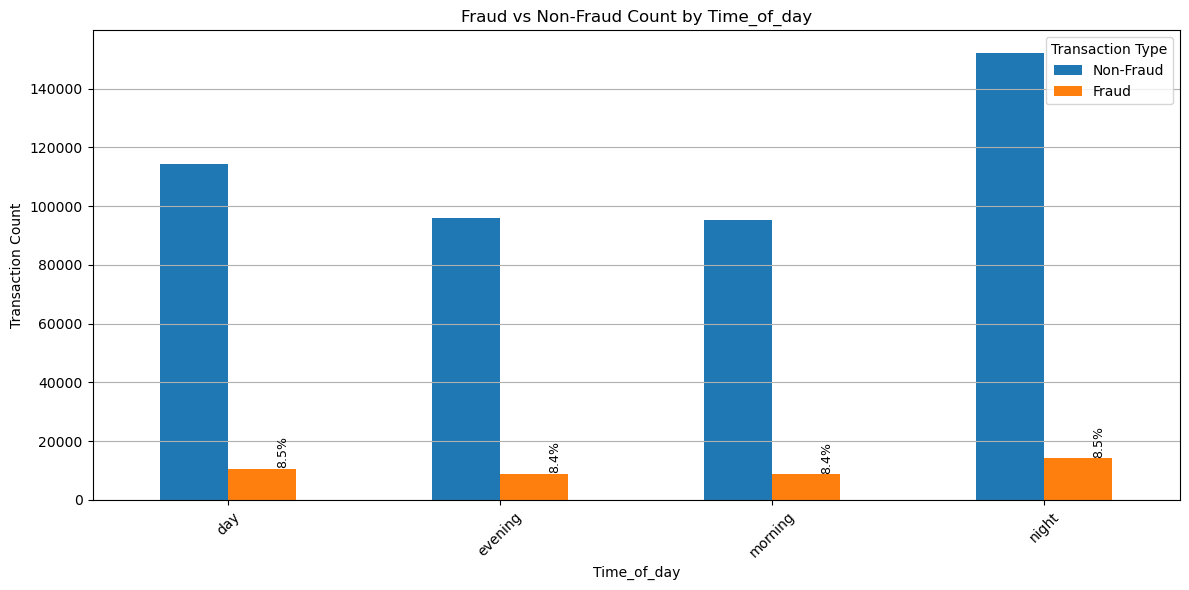

In [16]:
df['hour'] = df['timestamp'].dt.hour
df['time_of_day'] = df['hour'].apply(map_time_of_day)
plot_fraud_by_time(df, time_unit='time_of_day')

We conclude that a certain time of the transaction is not associated with higher risk of fraud. Since fraud shares are relatively the same across periods in the same time dimension we do not take into account time of the transaction. We could simulate real-world prediction by splitting train-test by timestamp - i.e. train on the past, test on the future. However the fraud rate is stable over time and time-based train-test split is not justified.

In [17]:
df.drop(columns=['hour', 'weekday', 'month', 'time_feature', 'time_of_day'], errors='ignore', inplace=True) #delete technical columns

Next, we assume that we have all possible transactions. This way we have a full history of transactions and are able to link user to frauds. Similar to merchant, we can create a flag that takes 1 if a user at least one prior fraud, otherwise - 0. We do not have methodology for the risk score of a user, therefore we assume that user-level fraud history indicator is not correlated with risk score, however we will still test it further. We also want to avoid data leakage, therefore we look only at earlier transactions by that user while computing flag. 

In [18]:
df = df.sort_values(by=['user_id', 'timestamp']) #sort to have chronological order
df['has_fraud_history_user'] = ( #cumulative max of fraud for each user up to before the current row
    df.groupby('user_id')['is_fraud'].transform(lambda x: x.shift().fillna(0).cumsum().gt(0).astype(int))
)
df['has_fraud_history_user'] = df['has_fraud_history_user'].fillna(0).astype(int) #handle the first transaction of user
df['has_fraud_history_user'].value_counts()

has_fraud_history_user
1    291467
0    208533
Name: count, dtype: int64

In [19]:
df.rename(columns={'has_fraud_history': 'has_fraud_history_merchant'}, inplace=True)
df['has_fraud_history_merchant'].value_counts()

has_fraud_history_merchant
1    260412
0    239588
Name: count, dtype: int64

Similar to merchant, we create account age in months for an user based on the signup date. 

In [20]:
def calculate_months_diff(start_date, end_date):
    '''number of months difference'''
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

In [21]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
today = pd.Timestamp.today() #the date of the modelling
df['account_age_months_user'] = df['signup_date'].apply(lambda x: calculate_months_diff(x, today))
df.rename(columns={'account_age_months': 'account_age_months_merchant'}, inplace=True)

In [22]:
df = df.drop(['signup_date'], axis=1) #not needed anymore

Initial attempt to link the geographical coordinates to a specific country is not successful because the number of unique coordinates is too large. Geographical API was used for that, however it has limited request capacity. Therefore, we decide to exclude latitude and longitude from the variable set. 

In [23]:
df = df.drop(['location.lat', 'location.long'], axis=1) 

### Visualized feature distribution (fraud vs non-fraud)

Before encoding the variables, we visualize their distribition to identify anomalies or patterns regarding fraud. 

### Outlier detection

In [24]:
def detect_outliers_iqr(data):
    '''outliers fall outside 1.5 * IQR above the third quartile or below the first'''
    outlier_flags = pd.DataFrame(index=data.index)
    for col in data.select_dtypes(include='number').columns: #only numerical
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_flags[col + '_outlier'] = (data[col] < lower_bound) | (data[col] > upper_bound) #new column detecting outliers
    return outlier_flags

In [25]:
outliers = detect_outliers_iqr(df)
#(df.index == outliers.index).all() #check if indices are the same
df_with_outliers = pd.concat([df, outliers], axis=1)

In [26]:
outlier_mask = df_with_outliers.filter(like='_outlier').any(axis=1) #keep only rows where any of the _outlier columns is True
df_with_any_outlier = df_with_outliers[outlier_mask]
df_with_any_outlier

,timestamp,user_id,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud,...,sum_of_monthly_installments_outlier,sum_of_monthly_expenses_outlier,risk_score_outlier,trust_score_outlier,number_of_alerts_last_6_months_outlier,avg_transaction_amount_outlier,account_age_months_merchant_outlier,has_fraud_history_merchant_outlier,has_fraud_history_user_outlier,account_age_months_user_outlier
95555,2022-08-09 12:30:00,U00001,22.94,online,iOS,credit_card,1,426,0,1,...,False,False,False,False,False,False,False,False,False,False
381637,2022-12-10 09:06:00,U00001,12.95,mobile,Web,credit_card,1,742,1,1,...,False,False,False,False,False,False,False,False,False,False
157928,2023-06-01 06:41:00,U00001,18.40,in-store,Android,bank_transfer,1,186,0,1,...,False,False,False,False,False,False,False,False,False,False
67571,2023-06-15 02:47:00,U00001,21.81,mobile,iOS,mobile_payment,1,842,1,0,...,False,False,False,False,False,True,False,False,False,False
229609,2022-06-14 23:23:00,U00002,7.86,mobile,iOS,debit_card,1,46,0,1,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497647,2023-08-18 01:42:00,U19999,2.46,mobile,Android,mobile_payment,0,831,1,0,...,False,False,False,False,False,False,False,False,False,False
146892,2023-09-24 22:42:00,U19999,5.85,mobile,Android,debit_card,1,438,0,1,...,False,False,False,False,False,False,False,False,False,False
107034,2023-10-04 16:26:00,U19999,223.56,mobile,iOS,mobile_payment,1,585,0,0,...,False,False,False,False,False,False,False,False,False,False
486057,2022-02-23 14:05:00,U20000,43.14,in-store,Web,mobile_payment,0,965,1,0,...,False,False,False,False,False,False,False,False,False,False


In [27]:
df_with_outliers.filter(like='_outlier').sum()

amount_outlier                            24250
is_international_outlier                  35669
session_length_seconds_outlier                0
is_first_time_merchant_outlier                0
is_fraud_outlier                          42411
age_outlier                                   0
sum_of_monthly_installments_outlier       23406
sum_of_monthly_expenses_outlier           22816
risk_score_outlier                         2841
trust_score_outlier                        2062
number_of_alerts_last_6_months_outlier     5900
avg_transaction_amount_outlier            17431
account_age_months_merchant_outlier           0
has_fraud_history_merchant_outlier            0
has_fraud_history_user_outlier                0
account_age_months_user_outlier               0
dtype: int64

CONCLUDE AFTER VISUAL INSPECTION

### Correlation analysis

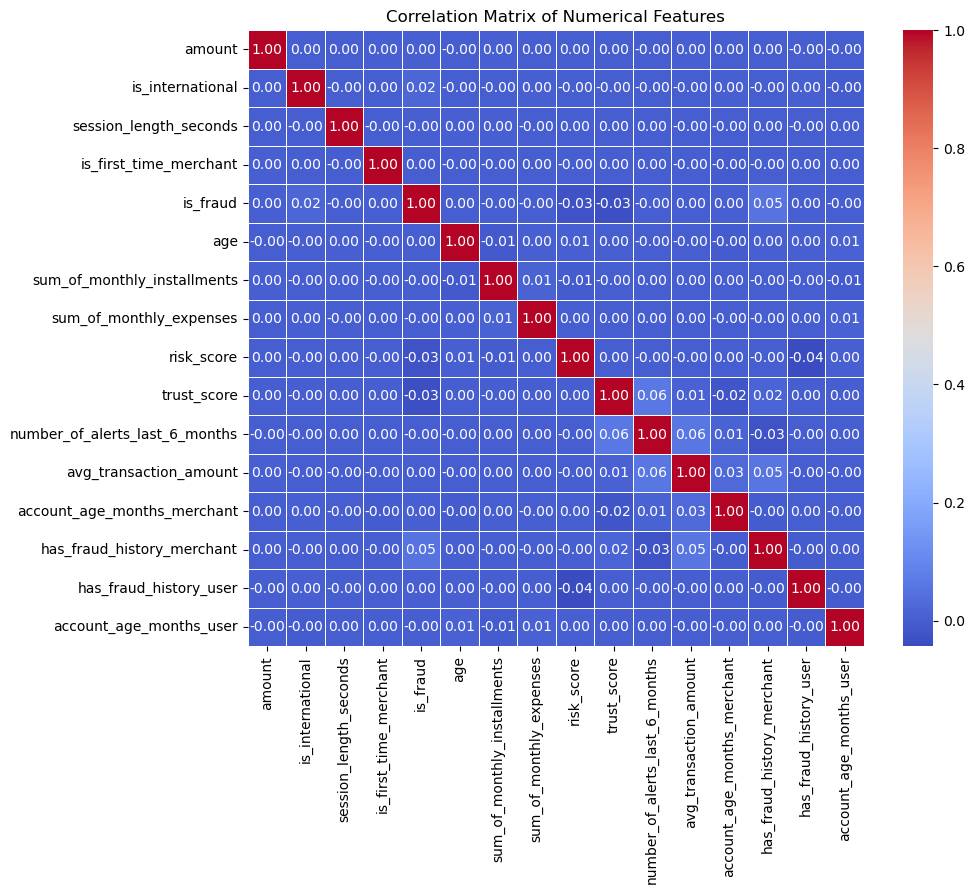

In [28]:
df_numeric = df.select_dtypes(include='number') #numeric features
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

No high correlation between regressors is observed. Expected correlation between **trust_score** and **has_fraud_history_merchant** / **risk_score** and **has_fraud_history_user** is not proved empirically. Features are not correlated with the target either. 

Final variable set presents as follows - timestamp and user_id may still be used in train-test split.

In [29]:
target_col = 'is_fraud'  #move target to the end
cols = [col for col in df.columns if col != target_col] + [target_col]
df = df[cols]

In [30]:
df.columns

Index(['timestamp', 'user_id', 'amount', 'channel', 'device', 'payment_method',
       'is_international', 'session_length_seconds', 'is_first_time_merchant',
       'age', 'sex', 'education', 'primary_source_of_income',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses',
       'country_user', 'risk_score', 'category', 'country_merchant',
       'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months_merchant',
       'has_fraud_history_merchant', 'has_fraud_history_user',
       'account_age_months_user', 'is_fraud'],
      dtype='object')

### Class imbalance

In [31]:
df['is_fraud'].value_counts()

is_fraud
0    457589
1     42411
Name: count, dtype: int64

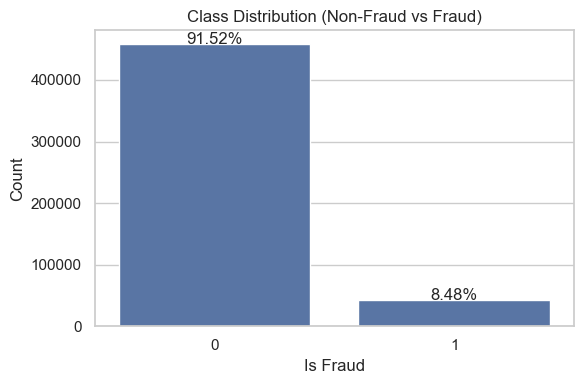

In [32]:
sns.set(style="whitegrid")
class_counts = df['is_fraud'].value_counts(normalize=True) * 100  #percentages instead of raw counts
labels = class_counts.index.tolist()
values = class_counts.values

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='is_fraud', data=df)

for i, v in enumerate(values):
    plt.text(i, v * len(df) / 100 + 100, f"{v:.2f}%", ha='center')

plt.title('Class Distribution (Non-Fraud vs Fraud)')
plt.xlabel('Is Fraud')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Class imbalance is clearly seen in the data. Models trained on such data tend to ignore the minority class (frauds) by predicting "non-fraud" all the time. To address this problem we use SMOTE technique (a kind of oversampling) that balance the dataset by creating synthetic examples of the frauds. It improves recall and is better than random oversampling - instead of duplicating, it generates new rows. SMOTE technique has drawbacks as it can introduce noisy or unrealistic samples, however we are safe while dealing with already synthetic data. 

# Train-test split with user grouping and SMOTE

SMOTE should only be applied to the training part of the data, hence we need to split the data first. According to the time-based analysis fraud rate does not change over time (year, month), that is why time-based split by timestamp is not used. Instead, we implement a Group Shuffle Split by user to avoid user leakage (the same user does not appear in both train and test). We have large dataset, therefore standard 80-20% ratio is accepted.

In [33]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #seed is used for replicability
for train_idx, test_idx in gss.split(df, groups=df['user_id']):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

In [34]:
train = train.drop(['timestamp', 'user_id'], axis=1) #not needed anymore
test = test.drop(['timestamp', 'user_id'], axis=1) #not needed anymore

In [35]:
print(train.shape)
print(test.shape)

(399797, 25)
(100203, 25)


In [36]:
train.head(10)

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user,is_fraud
33684,52.08,online,iOS,debit_card,1,237,1,36,Female,Bachelor,...,gaming,Ireland,0.321765,1,49.11,31,1,0,58,0
308730,19.22,mobile,Web,mobile_payment,1,262,0,36,Female,Bachelor,...,grocery,Finland,0.986760,2,11.01,95,1,0,58,0
231144,12.31,in-store,iOS,credit_card,1,908,1,36,Female,Bachelor,...,restaurants,Finland,1.000000,3,41.86,65,0,0,58,0
197693,49.03,in-store,Web,bank_transfer,1,733,1,36,Female,Bachelor,...,travel,Spain,0.817256,2,59.84,17,0,0,58,0
412248,14.21,in-store,Android,mobile_payment,1,858,0,36,Female,Bachelor,...,clothing,Ireland,0.639068,1,50.52,116,1,0,58,0
299567,25.36,mobile,Android,mobile_payment,1,139,0,36,Female,Bachelor,...,education,Belgium,0.693614,4,211.65,48,1,0,58,0
81088,21.09,mobile,iOS,mobile_payment,1,707,1,36,Female,Bachelor,...,travel,Denmark,1.000000,1,5.23,44,0,0,58,0
430619,141.85,in-store,Web,credit_card,1,991,1,36,Female,Bachelor,...,gaming,Poland,0.467349,2,89.82,116,0,0,58,0
229609,7.86,mobile,iOS,debit_card,1,46,0,36,Female,Bachelor,...,education,Italy,0.870627,3,33.33,28,0,0,58,1
69383,32.84,in-store,Web,debit_card,1,1167,1,36,Female,Bachelor,...,electronics,Belgium,0.607229,1,16.77,9,1,1,58,0


In [37]:
X_train = train.drop(columns=['is_fraud']) 
y_train = train['is_fraud']
X_test = test.drop(columns=['is_fraud'])
y_test = test['is_fraud']

SMOTE technique handles only numerical features, therefore categorical features need to be encoded. One-Hot encoding is not a good choice because we do not want to have unrealistic combinations in the generated rows (e.g. both category_gaming and category_clothing is 1 whereas in reality only one category can be valid). 

### Variable encoding

After visualization we can encode the categorical variables. Most ML models require numeric input - Logistic Regression, SVM, Neural Networks (MLPs) among others. Tree-based models - like CatBoost and latest versions of XGBoost - can directly ingest categorical features without preprocessing but in order to balance classes we need numeric input.

We implement 3 approaches for the encoding:
- Most categorical columns are label-encoded, that assumes ordinal meaning (i.e. 0<1<2), even if it is not true. Since we intend to mostly use tree-based models that handle categorical features it is not a big problem but for the application of linear SVM or MLPs another approach should be used. 
- Education levels have meaningful order, therefore they are encoded with integers reflecting it
- User and merchant countries have many unique categories, therefore can only be used in tree-based methods that handle them without assuming linear relationships. 

Education has ordinal meaning that is why it is encoded separately.

In [38]:
df['education'].value_counts()

education
PhD             103760
Master          100526
Bachelor        100325
High School      98823
No education     96566
Name: count, dtype: int64

In [39]:
education_order = ['No education', 'High School', 'Bachelor', 'Master', 'PhD']
X_train['education'] = pd.Categorical(X_train['education'], categories=education_order, ordered=True).codes
X_test['education'] = pd.Categorical(X_test['education'], categories=education_order, ordered=True).codes

In [40]:
categorical_cols = ['channel', 'device', 'payment_method', 'sex', 'primary_source_of_income', 'category', 'country_merchant', 'country_user']

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])  #same encoder for test
    label_encoders[col] = le

all_cat_cols = categorical_cols + ['education']
cat_indices = [X_train.columns.get_loc(col) for col in all_cat_cols]

smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42) #instance with random seed
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

#sanity check
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_resampled.value_counts())

Before SMOTE:
 is_fraud
0    365819
1     33978
Name: count, dtype: int64
After SMOTE:
 is_fraud
0    365819
1    365819
Name: count, dtype: int64


For models like Logistic Regression, SVM, MLPs we need to change the approach, since we do not want to mislead linear models to assume a numeric relationship (e.g. in-store as 0 is lower than online as 1) by using LabelEncoder. Therefore we use one-hot encoding and simple oversampling that duplicates the rows instead of generation. Countries of users and merchants are omitted.

In [70]:
one_hot_cols = ['channel', 'device', 'payment_method', 'sex', 'primary_source_of_income', 'category']
df_one_hot = pd.get_dummies(df, columns=one_hot_cols, drop_first=True, dtype=int) #avoid multicollinearity

In [71]:
df_one_hot['education'] = pd.Categorical(df_one_hot['education'], categories=education_order, ordered=True).codes #same Ordinal encoding
df_one_hot = df_one_hot.drop(['timestamp', 'user_id', 'country_user', 'country_merchant'], axis=1) #not needed anymore
cols = [col for col in df_one_hot.columns if col != target_col] + [target_col]
df_one_hot = df_one_hot[cols]
df_one_hot.columns

Index(['amount', 'is_international', 'session_length_seconds',
       'is_first_time_merchant', 'age', 'education',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'risk_score',
       'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months_merchant',
       'has_fraud_history_merchant', 'has_fraud_history_user',
       'account_age_months_user', 'channel_mobile', 'channel_online',
       'device_Web', 'device_iOS', 'payment_method_credit_card',
       'payment_method_debit_card', 'payment_method_mobile_payment',
       'sex_Male', 'sex_Other', 'primary_source_of_income_Employment',
       'primary_source_of_income_Retirement',
       'primary_source_of_income_Savings',
       'primary_source_of_income_Student Aid',
       'primary_source_of_income_Unemployment', 'category_education',
       'category_electronics', 'category_gaming', 'category_grocery',
       'category_restaurants', 'category_travel', 'is_fraud'],
      dt

We do not want to lose a lot of non-fraud data with undersampling approach, therefore basic oversampling is used - fraud rows are duplicated to balance the classes.

In [72]:
X_lin = df_one_hot.drop(columns=['is_fraud'])
y_lin = df_one_hot['is_fraud']
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42, stratify=y_lin) #preserve fraud ratio

In [73]:
train_data_lin = pd.concat([X_train_lin, y_train_lin], axis=1)
majority = train_data_lin[train_data_lin['is_fraud'] == 0]
minority = train_data_lin[train_data_lin['is_fraud'] == 1]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42) #duplicate rows with replacement
train_upsampled = pd.concat([majority, minority_upsampled])
train_upsampled = train_upsampled.sample(frac=1, random_state=42) #shuffle
X_train_lin_resampled = train_upsampled.drop(columns=['is_fraud'])
y_train_lin_resampled = train_upsampled['is_fraud']

# Training the models

X_train - LabelEncoder without oversampling

X_train_resampled - LabelEncoder with SMOTE for tree-based models

X_train_lin_resampled - One-Hot encoder with basic oversampling for SVM / MLPs

In [74]:
X_train

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user
33684,52.08,2,2,2,1,237,1,36,0,2,...,0.705268,3,7,0.321765,1,49.11,31,1,0,58
308730,19.22,1,1,3,1,262,0,36,0,2,...,0.705268,4,4,0.986760,2,11.01,95,1,0,58
231144,12.31,0,2,1,1,908,1,36,0,2,...,0.705268,5,4,1.000000,3,41.86,65,0,0,58
197693,49.03,0,1,0,1,733,1,36,0,2,...,0.705268,6,12,0.817256,2,59.84,17,0,0,58
412248,14.21,0,0,3,1,858,0,36,0,2,...,0.705268,0,7,0.639068,1,50.52,116,1,0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263172,35.83,0,2,2,1,967,0,50,0,0,...,0.607373,5,9,0.915723,7,158.60,15,1,0,33
360206,21.69,1,1,0,1,952,1,50,0,0,...,0.607373,6,8,1.000000,3,25.54,14,1,0,33
358294,39.16,0,2,3,1,773,0,50,0,0,...,0.607373,0,4,0.413113,4,86.73,25,0,0,33
251399,134.76,0,0,3,1,504,1,50,0,0,...,0.607373,5,6,0.531957,2,45.86,87,0,0,33


In [75]:
X_train_resampled

,amount,channel,device,payment_method,is_international,session_length_seconds,is_first_time_merchant,age,sex,education,...,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months_merchant,has_fraud_history_merchant,has_fraud_history_user,account_age_months_user
0,52.080000,2,2,2,1,237,1,36,0,2,...,0.705268,3,7,0.321765,1,49.110000,31,1,0,58
1,19.220000,1,1,3,1,262,0,36,0,2,...,0.705268,4,4,0.986760,2,11.010000,95,1,0,58
2,12.310000,0,2,1,1,908,1,36,0,2,...,0.705268,5,4,1.000000,3,41.860000,65,0,0,58
3,49.030000,0,1,0,1,733,1,36,0,2,...,0.705268,6,12,0.817256,2,59.840000,17,0,0,58
4,14.210000,0,0,3,1,858,0,36,0,2,...,0.705268,0,7,0.639068,1,50.520000,116,1,0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731633,94.445881,0,0,3,1,345,1,60,2,3,...,0.563957,5,1,0.620429,3,85.955622,111,0,0,17
731634,129.383881,1,0,0,1,506,0,69,1,1,...,0.525788,6,2,0.817633,4,43.099513,12,1,0,35
731635,26.418651,2,0,1,1,259,0,35,1,1,...,0.721302,0,3,0.755612,2,30.340397,113,0,0,14
731636,54.353282,2,2,3,1,1129,0,70,0,2,...,0.596104,0,2,0.786997,2,228.271779,46,0,0,59


In [76]:
X_train_lin_resampled

,amount,is_international,session_length_seconds,is_first_time_merchant,age,education,sum_of_monthly_installments,sum_of_monthly_expenses,risk_score,trust_score,...,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment,category_education,category_electronics,category_gaming,category_grocery,category_restaurants,category_travel
29357,18.93,1,311,0,18,4,114.29,1497.44,0.287482,0.757205,...,1,0,0,0,0,0,0,1,0,0
280660,66.13,1,1078,0,61,3,35.49,85.17,0.620680,0.450036,...,0,0,0,0,0,0,0,0,1,0
161717,82.53,1,551,0,38,1,749.43,766.99,0.238467,0.936983,...,0,0,0,0,0,1,0,0,0,0
298454,7.10,1,251,0,40,4,68.54,1420.96,0.501115,0.387394,...,0,0,0,0,0,0,0,0,0,0
418692,16.56,1,383,0,64,0,138.02,291.11,0.623444,0.493281,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14585,21.81,1,667,1,55,3,101.76,310.38,0.490489,0.940136,...,0,0,0,1,0,0,0,1,0,0
15156,65.49,1,153,1,55,4,47.93,314.57,0.522854,0.694263,...,0,0,0,0,1,0,0,0,0,0
343913,121.50,1,288,1,55,2,59.96,2699.21,0.429015,1.000000,...,0,1,0,0,0,1,0,0,0,0
185040,0.93,1,314,1,65,3,601.06,421.67,0.743732,0.665570,...,0,0,0,1,0,0,0,0,1,0


Only after training and predictions (fit and predict) we can go back to original categories for better interpretability

In [ ]:
#for col in label_encoders: #make sure to run encoding
#    X_train[col] = label_encoders[col].inverse_transform(X_train[col])